# Kaggle House Price Challenge (Ames, Iowa) : 
<p><a name="sections"></a></p>

## Sections
- <a href="#cont_transform">Continuous Data Transformation</a><br>
- <a href="#trees">Decision Trees</a><br>
 - <a href="#trees_plot">Plots: Sweep Hyperparameter</a><br>
 - <a href="#trees_cvgrid">CV Grid Search</a><br>
 - <a href="#trees_bestmodel">Create Trees Best Model</a><br>
 - <a href="#trees_plot">Plot: Variable Importance</a><br>
- <a href="#forest">Random Forests</a><br>
 - <a href="#forest_plot">Plots: Sweep Hyperparameter</a><br>
 - <a href="#forest_cvgrid">CV Grid Search</a><br>
 - <a href="#forest_bestmodel">Create Random Forest Best Model</a><br>
- <a href="#gboost">Gradient Boosting</a><br>
 - <a href="#gboost_plot">Plots: Sweep Hyperparameter</a><br>
 - <a href="#gboost_cvgrid">CV Grid Search</a><br>
 - <a href="#gboost_bestmodel">Create Gradient Boost Best Model</a><br>
- <a href="#kaggle">Kaggle Submissions</a><br>
 - <a href="#kaggle_trees">Best Predictions : Decision Trees</a><br>
 - <a href="#kaggle_forest">Best Predictions : Random Forests</a><br>
 - <a href="#kaggle_gboost">Best Predictions : Gradient Boosting</a><br>
 - <a href="#kaggle_result">Kaggle Results : Root-Mean-Square-Log-Error</a><br>
- <a href="#predplot_trees">Prediction Plots : Trees </a><br>

In [23]:
import pandas as pd
import numpy as np
import math

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from scipy.stats import skew

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
%matplotlib inline

plt.style.use('ggplot')

In [24]:
pd.set_option('display.max_columns', 100)

train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

In [25]:
# Save the 'Id' column
train_ID = train_df['Id']
test_ID = test_df['Id']

# Now drop the 'Id' colum since we can not use it as a feature to train our model.
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

In [26]:
def is_outlier(points, thresh = 3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [27]:
Y_TRAIN= train_df['SalePrice']
X_TRAIN = train_df.drop('SalePrice', axis=1)
X_TEST = test_df.copy()

In [28]:
#del train_df, test_df
print(X_TRAIN.shape)
print(X_TEST.shape)

(1460, 79)
(1459, 79)


In [29]:
Y_TRAIN=np.log(Y_TRAIN)
#print(Y_TRAIN)

In [30]:
all_data = pd.concat([X_TRAIN, X_TEST])
all_data.shape

(2919, 79)

#### Find all Categorical Data

In [31]:
cats = []
for col in all_data.columns.values:
    if all_data[col].dtype == 'object':
        cats.append(col)

#### Create Separate Continuous Data

In [32]:
df_cont = all_data.drop(cats, axis=1)
df_cat = all_data[cats]

In [33]:
df_cont_copy=df_cont.copy()

### Handle Missing Data for continuous data
- If any column contains more than 50 entries of missing data, drop the column
- If any column contains fewer that 50 entries of missing data, replace those missing values with the median for that column
- Remove outliers using Median Absolute Deviation
- Calculate skewness for each variable and if greater than 0.75 transform it
- Apply the sklearn.Normalizer to each column

In [34]:
for col in df_cont.columns.values:
    if np.sum(df_cont[col].isnull()) > 50:
        df_cont = df_cont.drop(col, axis = 1)
    elif np.sum(df_cont[col].isnull()) > 0:
        median = df_cont[col].median()
        idx = np.where(df_cont[col].isnull())[0]
        df_cont[col].iloc[idx] = median

        outliers = np.where(is_outlier(df_cont[col]))
        #print(outliers)
        df_cont[col].iloc[outliers] = median
        
    elif skew(df_cont[col]) > 0.75:
        #print("Skewness (>0.75) = %s" %(col))
        df_cont[col] = np.log(df_cont[col])
        df_cont[col] = df_cont[col].apply(lambda x: 0 if x == -np.inf else x)

        df_cont[col] = Normalizer().fit_transform(df_cont[col].reshape(1,-1))[0]

C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  

<p><a name="cont_transform"></a></p>
## Continuous Data Transformation

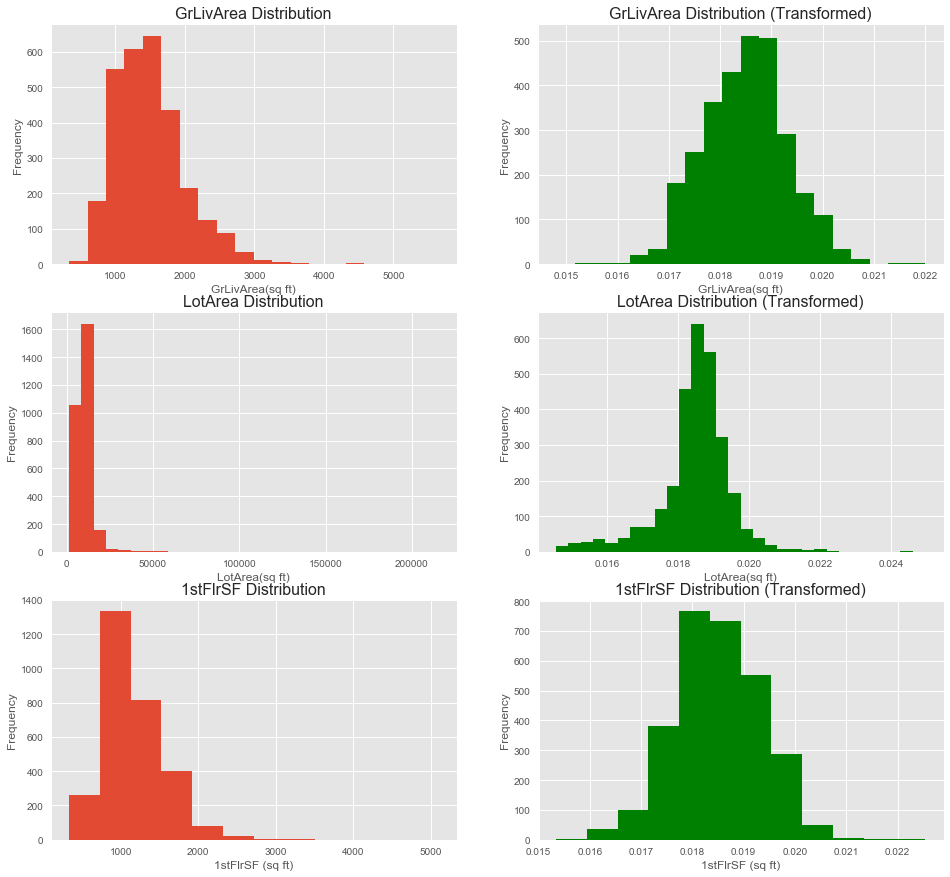

In [35]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 15))
#fig.suptitle("Pre-Transformation                                         Post-Transformation", fontsize=22)
plt.subplot(3, 2, 1)
plt.hist(df_cont_copy['GrLivArea'],bins=20)
plt.title('GrLivArea Distribution', fontsize=16)
plt.ylabel('Frequency')
plt.xlabel('GrLivArea(sq ft)')

plt.subplot(3, 2, 2)
plt.title('GrLivArea Distribution (Transformed)', fontsize=16)
plt.hist(df_cont['GrLivArea'],bins=20,color='g')
plt.ylabel('Frequency')
plt.xlabel('GrLivArea(sq ft)')

plt.subplot(3, 2, 3)
plt.title('LotArea Distribution', fontsize=16)
plt.hist(df_cont_copy['LotArea'],bins=30)
plt.ylabel('Frequency')
plt.xlabel('LotArea(sq ft)')

plt.subplot(3, 2, 4)
plt.title('LotArea Distribution (Transformed)', fontsize=16)
plt.hist(df_cont['LotArea'],bins=30,color='g')
plt.ylabel('Frequency')
plt.xlabel('LotArea(sq ft)')

plt.subplot(3, 2, 5)
plt.title('1stFlrSF Distribution', fontsize=16)
plt.hist(df_cont_copy['1stFlrSF'],bins=12)
plt.ylabel('Frequency')
plt.xlabel('1stFlrSF (sq ft)')

plt.subplot(3, 2, 6)
plt.title('1stFlrSF Distribution (Transformed)', fontsize=16)
plt.hist(df_cont['1stFlrSF'],bins=12,color='g')
plt.ylabel('Frequency')
plt.xlabel('1stFlrSF (sq ft)')


#### Handle Missing Data for Categorical Data

- If any column contains more than 50 entries of missing data, drop the column
- If any column contains fewer that 50 entries of missing data, replace those values with the 'MIA'
- Apply the sklearn.LabelEncoder
- For each categorical variable determine the number of unique values and for each, create a new column that is binary



In [36]:
for col in df_cat.columns.values:
    if np.sum(df_cat[col].isnull()) > 50:
        df_cat = df_cat.drop(col, axis = 1)
        continue
    elif np.sum(df_cat[col].isnull()) > 0:
        df_cat[col] = df_cat[col].fillna('MIA')
        
    df_cat[col] = LabelEncoder().fit_transform(df_cat[col])
    
    num_cols = df_cat[col].max()
    for i in range(num_cols):
        col_name = col + '_' + str(i)
        df_cat[col_name] = df_cat[col].apply(lambda x: 1 if x == i else 0)
        
    df_cat = df_cat.drop(col, axis = 1)

C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\cmlim\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [37]:
df_cat.shape

(2919, 171)

In [38]:
all_data=pd.concat([df_cont, df_cat], axis = 1)
X_TRAIN = all_data.iloc[0:1460,]
X_TEST = all_data.iloc[1460:,]

In [39]:
print(X_TRAIN.shape)
print(Y_TRAIN.shape)
print(X_TEST.shape)

(1460, 205)
(1460,)
(1459, 205)


In [40]:
#Write Processed Data to File
X_TRAIN.to_csv('X_TRAIN.csv')
Y_TRAIN.to_csv('Y_TRAIN.csv')
X_TEST.to_csv('X_TEST.csv')

### Create Test/Train Split

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X_TRAIN, Y_TRAIN, test_size = .25, random_state=5)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1095, 205)
(1095,)
(365, 205)
(365,)


In [42]:
tree_model = tree.DecisionTreeRegressor(min_samples_leaf=10,max_depth=9)
tree_model.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [43]:
#tree_model.feature_importances_

In [44]:
def calc_rmsle (tree_model, x_input, y_input):
    msle=np.mean(( y_input-tree_model.predict(x_input))** 2)
    return(math.sqrt(msle))

In [45]:
calc_rmsle(tree_model,x_test,y_test)

0.19100427008847173

<p><a name="trees"></a></p>
## Decision Trees

### Depth of Tree

In [70]:
depth = range(1, 18)
depth_train_error = []
depth_test_error = []
tree_model = tree.DecisionTreeRegressor()
for i in depth:
    tree_model.set_params(max_depth=i, min_samples_leaf=1)
    tree_model.fit(x_train, y_train)
    depth_train_error.append(calc_rmsle(tree_model,x_train,y_train))
    depth_test_error.append(calc_rmsle(tree_model,x_test,y_test))

### Minimum Number of Samples per Leaf

In [71]:
leaf = range(1, 30)
leaf_train_error = []
leaf_test_error = []
tree_model = tree.DecisionTreeRegressor()
for i in leaf:
    tree_model.set_params( min_samples_leaf=i)
    tree_model.fit(x_train, y_train)
    leaf_train_error.append(calc_rmsle(tree_model,x_train,y_train))
    leaf_test_error.append(calc_rmsle(tree_model,x_test,y_test))

<p><a name="trees_plot"></a></p>
### Plots : Sweep Tree Depth & Minimum Sample per Leaf 

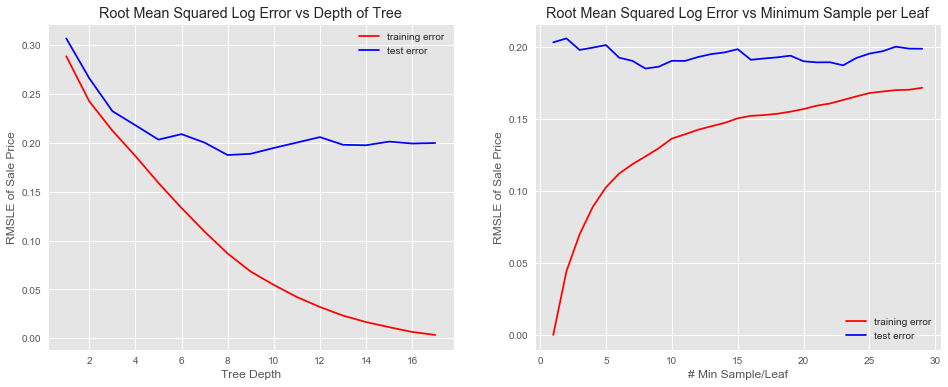

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
#plt.figure(figsize=(9, 6))
plt.subplot(1, 2, 1)
#plt.fig
plt.plot(depth, depth_train_error, c='red', label='training error')
plt.plot(depth, depth_test_error, c='blue', label='test error')
plt.legend()
plt.ylabel('RMSLE of Sale Price')
plt.xlabel('Tree Depth')
plt.title('Root Mean Squared Log Error vs Depth of Tree')

plt.subplot(1, 2, 2)
plt.plot(leaf, leaf_train_error, c='red', label='training error')
plt.plot(leaf, leaf_test_error, c='blue', label='test error')
plt.legend()
plt.ylabel('RMSLE of Sale Price')
plt.xlabel('# Min Sample/Leaf')
plt.title('Root Mean Squared Log Error vs Minimum Sample per Leaf')
plt.show()

<p><a name="trees_cvgrid"></a></p>
### CV Grid Search for Decision Tree

In [73]:
grid_para_tree = [{
    "criterion": ["mse"],
    "max_depth": range(1, 30),
    "min_samples_leaf": np.linspace(start=2, stop=30, num=15, dtype=int)
}]
tree_model.set_params(random_state=0)
grid_search_tree = GridSearchCV(tree_model, grid_para_tree, cv=5,scoring='neg_mean_squared_error', n_jobs=-1)
%time grid_search_tree.fit(x_train, y_train)

Wall time: 23.8 s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=29, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'max_depth': range(1, 30), 'criterion': ['mse'], 'min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [74]:
## best parameters
print(grid_search_tree.best_params_)
rmsle_grid_tree_train=calc_rmsle(grid_search_tree,x_train,y_train)
rmsle_grid_tree_test=calc_rmsle(grid_search_tree,x_test,y_test)
print(rmsle_grid_tree_train)
print(rmsle_grid_tree_test)

{'max_depth': 9, 'criterion': 'mse', 'min_samples_leaf': 10}
0.1374470662167449
0.19100427008847184


<p><a name="trees_bestmodel"></a></p>
## Create Best Tree Model
- Pass Best Parameters to Best Model
- Train Best Model with FULL Train Set

In [75]:
best_tree_model=tree.DecisionTreeRegressor(**grid_search_tree.best_params_)
best_tree_model.fit(X=X_TRAIN,y=Y_TRAIN)
calc_rmsle(best_tree_model,x_test,y_test)

0.12963576756256778

In [76]:
best_tree_model.predict(x_test)
rmsle_best_tree_train=calc_rmsle(best_tree_model,x_train,y_train)
rmsle_best_tree_test=calc_rmsle(best_tree_model,x_test,y_test)
print(rmsle_best_tree_train)
print(rmsle_best_tree_test)

0.13422326226750209
0.12963576756256778


<p><a name="trees_plot2"></a></p>
### Plot: Feature Importance

In [77]:
feature_importance = list(zip(x_train.columns, best_tree_model.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')
#[::-1]
#feature_sort

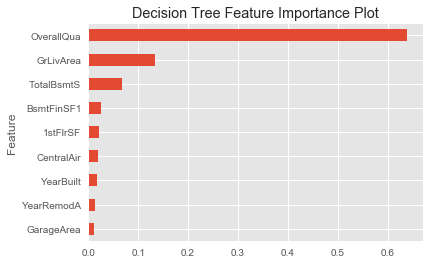

In [78]:
feature_name=[i.decode("utf-8") for (i, j) in feature_sort if j>0.01]
feature_val=[j for (i, j) in feature_sort if j>0.01]
#feature_sort.
fimp_df=pd.DataFrame({'Feature':feature_name,'Importance':feature_val}).reset_index(drop=True)
#fimp_df.plot.barh(x='Feature',y='Importance')
fimp_df.plot(kind='barh',x='Feature',y='Importance',
             legend=None, title='Decision Tree Feature Importance Plot')

<p><a name="forest"></a></p>
## Random Forest

In [46]:
rf_model = RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [47]:
rf_model.fit(x_train, y_train)
msle=np.mean(( y_test-rf_model.predict(x_test))** 2)
math.sqrt(msle)

0.13579864514326803

In [81]:
rf_model = RandomForestRegressor(min_samples_leaf=10,max_depth=9,n_jobs=-1)
ntrees_range = range(20, 500, 25)  # OOB score will warning if too few trees
ntrees_train_error = []
ntrees_test_error = []
oob_error = []

for ntrees in ntrees_range:
    rf_model.set_params(n_estimators=ntrees, random_state=0,  oob_score=True)
    rf_model.fit(x_train, y_train)
    ntrees_train_error.append(calc_rmsle(rf_model,x_train,y_train))
    ntrees_test_error.append(calc_rmsle(rf_model,x_test,y_test))

<p><a name="forest_plot"></a></p>
### Plot: Sweep Hyperparameter Number of Trees

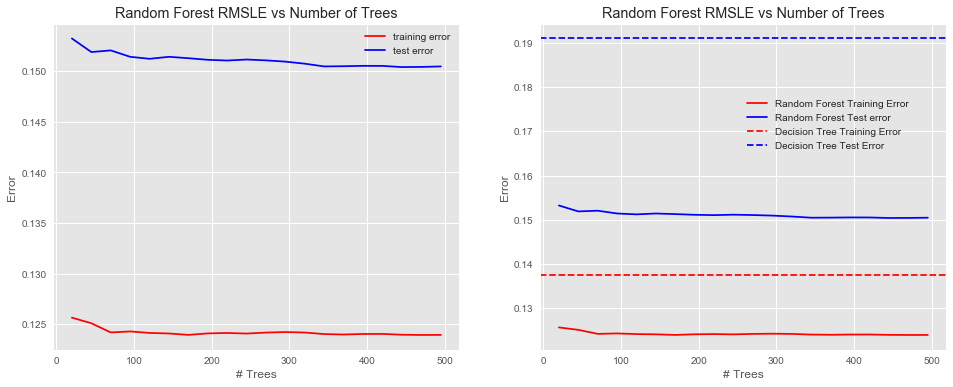

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(ntrees_range, ntrees_train_error, c='red', label='training error')
plt.plot(ntrees_range, ntrees_test_error, c='blue', label='test error')
plt.ylabel('Error')
plt.xlabel('# Trees')
plt.title('Random Forest RMSLE vs Number of Trees')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ntrees_range, ntrees_train_error, c='red', label='Random Forest Training Error')
plt.plot(ntrees_range, ntrees_test_error, c='blue', label='Random Forest Test error')
plt.axhline(y=rmsle_grid_tree_train,ls='--',c='red',label='Decision Tree Training Error')
plt.axhline(y=rmsle_grid_tree_test,ls='--',c='blue',label='Decision Tree Test Error')
rmsle_best_tree_train
plt.ylabel('Error')
plt.xlabel('# Trees')
plt.title('Random Forest RMSLE vs Number of Trees')

plt.legend(loc=(0.5,0.6))
plt.show()

<p><a name="forest_cvgrid"></a></p>
### CV Grid Search for Random Forest

In [52]:
grid_search_forest = RandomForestRegressor(n_jobs=-1)
grid_para_forest = [{
    "n_estimators": [200,300,400],
    "criterion": ["mse"],
    #"min_samples_split": [5,10,30,50,70]
    "min_samples_leaf": np.linspace(start=10, stop=20, num=4, dtype=int)
    }]
grid_search_forest = GridSearchCV(grid_search_forest, grid_para_forest, 
                                  scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
%time grid_search_forest.fit(x_train, y_train)

Wall time: 1min 9s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [200, 300, 400], 'min_samples_leaf': array([10, 13, 16, 20]), 'criterion': ['mse']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [53]:
print(grid_search_forest.best_params_)
print(grid_search_forest.get_params)

{'n_estimators': 300, 'min_samples_leaf': 10, 'criterion': 'mse'}
<bound method BaseEstimator.get_params of GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [200, 300, 400], 'min_samples_leaf': array([10, 13, 16, 20]), 'criterion': ['mse']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)>


<p><a name="forest_bestmodel"></a></p>
## Create Best Random Forest Model
- Pass Best Parameters to Best Model
- Train Best Model with FULL Train Set

In [54]:
## best parameters
print(grid_search_forest.best_params_)
rmsle_grid_forest_train=calc_rmsle(grid_search_forest,x_train,y_train)
rmsle_grid_forest_test=calc_rmsle(grid_search_forest,x_test,y_test)
print(rmsle_grid_forest_train)
print(rmsle_grid_forest_test)

{'n_estimators': 300, 'min_samples_leaf': 10, 'criterion': 'mse'}
0.1246117942503441
0.15185888486507598


In [55]:
best_forest_model=RandomForestRegressor(**grid_search_forest.best_params_)
best_forest_model.fit(X=X_TRAIN,y=Y_TRAIN)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [56]:
best_forest_model.predict(x_test)
rmsle_best_forest_train=calc_rmsle(best_forest_model,x_train,y_train)
rmsle_best_forest_test=calc_rmsle(best_forest_model,x_test,y_test)
print(rmsle_best_forest_train)
print(rmsle_best_forest_test)

0.12135270765889797
0.11142081744180733


<p><a name="gboost"></a></p>
## Gradient Boosting

In [57]:
gboost_model = GradientBoostingRegressor()
learnrate_range = learnrate_range = [10**i for i in np.arange(-4.,0,.25)]
#print(learnrate_range)
gboost_train_error = []
gboost_test_error = []
oob_error = []

for learnrate in learnrate_range:
    gboost_model.set_params(learning_rate=learnrate, random_state=0,n_estimators=100)
    gboost_model.fit(x_train, y_train)
    gboost_train_error.append(calc_rmsle(gboost_model,x_train,y_train))
    gboost_test_error.append(calc_rmsle(gboost_model,x_test,y_test))

In [58]:
print(learnrate_range)

[0.0001, 0.00017782794100389227, 0.00031622776601683794, 0.0005623413251903491, 0.001, 0.0017782794100389228, 0.0031622776601683794, 0.005623413251903491, 0.01, 0.017782794100389229, 0.031622776601683791, 0.056234132519034911, 0.10000000000000001, 0.17782794100389229, 0.31622776601683794, 0.56234132519034907]


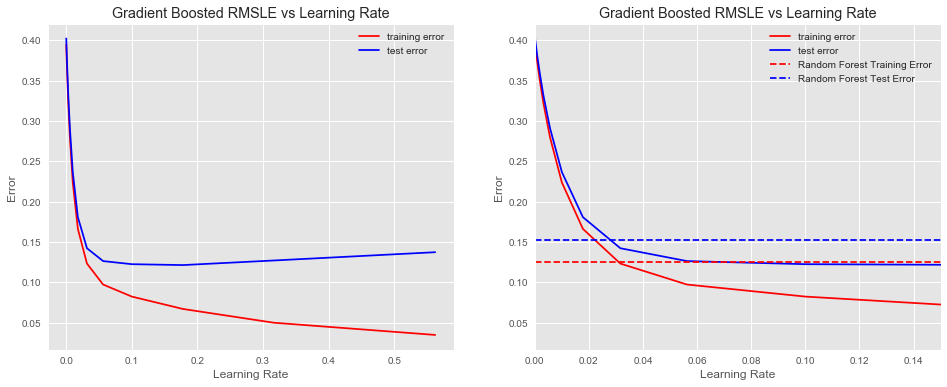

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(learnrate_range, gboost_train_error, c='red', label='training error')
plt.plot(learnrate_range, gboost_test_error, c='blue', label='test error')
plt.ylabel('Error')
plt.xlabel('Learning Rate')
plt.title('Gradient Boosted RMSLE vs Learning Rate')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(learnrate_range, gboost_train_error, c='red', label='training error')
plt.plot(learnrate_range, gboost_test_error, c='blue', label='test error')
plt.axhline(y=rmsle_grid_forest_train,ls='--',c='red',label='Random Forest Training Error')
plt.axhline(y=rmsle_grid_forest_test,ls='--',c='blue',label='Random Forest Test Error')
plt.ylabel('Error')
plt.xlabel('Learning Rate')
plt.title('Gradient Boosted RMSLE vs Learning Rate')
plt.xlim([0,0.15])
plt.legend()

<p><a name="gboost_cvgrid"></a></p>
### CV Grid Search for Gradient Boosting

In [ ]:
grid_search_gboost = GradientBoostingRegressor()
grid_para_gboost = [{
    "learning_rate": [0.04,0.05,0.06],
    "n_estimators": [100, 200, 300],
    "min_samples_split": [50,100,150]
    }]
grid_search_gboost = GridSearchCV(grid_search_gboost, grid_para_gboost, 
                                  scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
%time grid_search_gboost.fit(x_train, y_train)

In [ ]:
print(grid_search_gboost.best_params_)
calc_rmsle(grid_search_gboost,x_test,y_test)

In [ ]:
calc_rmsle(grid_search_gboost,x_train,y_train)

<p><a name="gboost_bestmodel"></a></p>
## Create Best Gradient Boost Model
- Pass Best Parameters to Best Model
- Train Best Model with FULL Train Set

In [ ]:
best_gboost_model=GradientBoostingRegressor(**grid_search_gboost.best_params_)
best_gboost_model.fit(X=X_TRAIN,y=Y_TRAIN)
calc_rmsle(best_gboost_model,x_test,y_test)

In [ ]:
best_gboost_model.predict(x_test)
rmsle_best_gboost_train=calc_rmsle(best_gboost_model,x_train,y_train)
rmsle_best_gboost_test=calc_rmsle(best_gboost_model,x_test,y_test)
print(rmsle_best_gboost_train)
print(rmsle_best_gboost_test)

<p><a name="kaggle"></a></p>
## Kaggle Submission

<p><a name="kaggle_trees"></a></p>
### Best Model Decision Tree

In [ ]:
trees_pred=np.exp(best_tree_model.predict(X_TEST))
kaggle_trees_df=pd.DataFrame({'Id':test_ID,'SalePrice':trees_pred})
kaggle_trees_df.to_csv('kaggle_trees_df.csv',index=None)
kaggle_trees_df.head()

<p><a name="kaggle_forest"></a></p>
### Best Model Random Forest

In [ ]:
forest_pred=np.exp(best_forest_model.predict(X_TEST))
kaggle_forest_df=pd.DataFrame({'Id':test_ID,'SalePrice':forest_pred})
kaggle_forest_df.to_csv('kaggle_forest_df.csv',index=None)
kaggle_forest_df.head()

<p><a name="kaggle_gboost"></a></p>
### Best Model Gradient Boosting

In [94]:
gboost_pred=np.exp(best_gboost_model.predict(X_TEST))
kaggle_gboost_df=pd.DataFrame({'Id':test_ID,'SalePrice':gboost_pred})
kaggle_gboost_df.to_csv('kaggle_gboost_df.csv',index=None)
kaggle_gboost_df.head()


,Id,SalePrice
0,1461,124482.417301
1,1462,154833.780481
2,1463,184013.902377
3,1464,197970.976446
4,1465,191709.942546


<p><a name="kaggle_result"></a></p>
### Kaggle RMSLE

In [334]:
kaggle_trees_rmsle=0.18817
kaggle_forest_rmsle=0.14652
kaggle_gboost_rmsle=0.13338

<p><a name="predplot_trees"></a></p>
### Prediction Plots - Decision Trees

In [211]:
worst_tree_model = tree.DecisionTreeRegressor(min_samples_leaf=50,max_depth=3)
worst_tree_model.fit(X_TRAIN,Y_TRAIN)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=50, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [244]:
type(Y_TRAIN)
trees_price_df=pd.DataFrame({
    'Train_Price':np.exp(Y_TRAIN),
    'Worst_Tree_Price':np.exp(worst_tree_model.predict(X_TRAIN)),
    'Best_Tree_Price':np.exp(best_tree_model.predict(X_TRAIN))})
trees_price_df=trees_price_df.sort_values('Train_Price')
trees_price_df.head()

,Best_Tree_Price,Train_Price,Worst_Tree_Price
495,61084.675721,34900.0,99703.360278
916,61084.675721,35311.0,99703.360278
968,76425.073160,37900.0,99703.360278
533,61084.675721,39300.0,99703.360278
30,76425.073160,40000.0,99703.360278


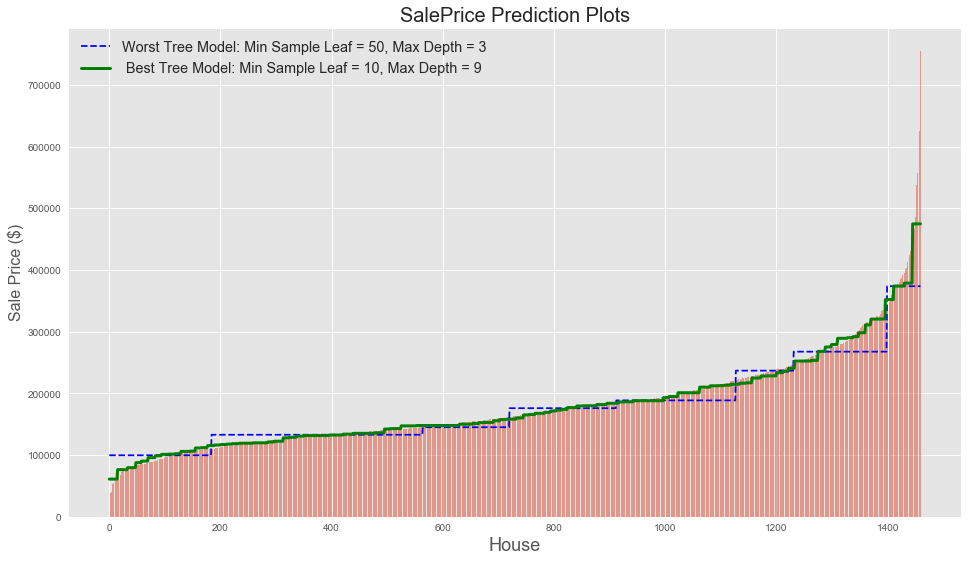

In [245]:
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('x-large')
plt.figure(figsize=(16, 9))
plt.bar(range(0,Y_TRAIN.shape[0]),np.exp(sorted(Y_TRAIN)),alpha=0.5)
plt.plot(range(0,Y_TRAIN.shape[0]),np.exp(sorted(worst_tree_model.predict(X_TRAIN))),color='b',
        linestyle='--', label='Worst Tree Model: Min Sample Leaf = 50, Max Depth = 3')
plt.plot(range(0,Y_TRAIN.shape[0]),np.exp(sorted(best_tree_model.predict(X_TRAIN))),color='g',
        linewidth=3, label=' Best Tree Model: Min Sample Leaf = 10, Max Depth = 9')
plt.legend(prop = fontP)
plt.title('SalePrice Prediction Plots : Decision Trees',fontsize=20)
plt.xlabel('House', fontsize=18)
plt.ylabel('Sale Price ($)', fontsize=16)

<p><a name="predplot_forest"></a></p>
### Prediction Plots - Random Forests

In [67]:
worst_forest_model = RandomForestRegressor(max_depth=3,n_estimators=30)
worst_forest_model.fit(X_TRAIN,Y_TRAIN)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [71]:
forest_price_df=pd.DataFrame({
    'Train_Price':np.exp(Y_TRAIN),
    'Worst_Forest_Price':np.exp(worst_forest_model.predict(X_TRAIN)),
    'Best_Forest_Price':np.exp(best_forest_model.predict(X_TRAIN))})
forest_price_df=forest_price_df.sort_values('Train_Price')
forest_price_df.head()

,Best_Forest_Price,Train_Price,Worst_Forest_Price
495,49472.842546,34900.0,92771.061470
916,48427.625769,35311.0,89192.226449
968,52857.364080,37900.0,87014.326515
533,48029.616623,39300.0,88106.842420
30,61533.494942,40000.0,100865.350878


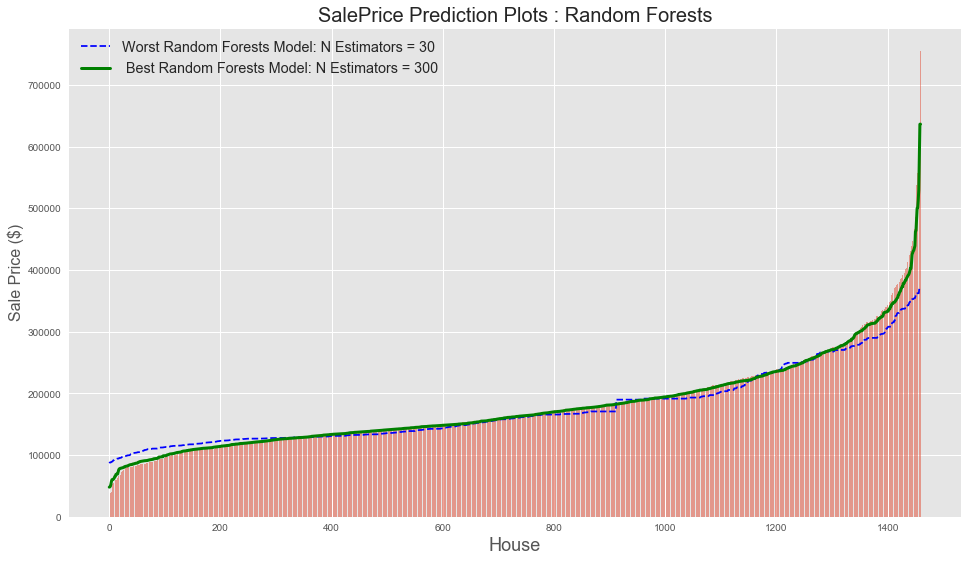

In [72]:
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('x-large')
plt.figure(figsize=(16, 9))
plt.bar(range(0,Y_TRAIN.shape[0]),np.exp(sorted(Y_TRAIN)),alpha=0.5)
plt.plot(range(0,Y_TRAIN.shape[0]),np.exp(sorted(worst_forest_model.predict(X_TRAIN))),color='b',
        linestyle='--', label='Worst Random Forests Model: N Estimators = 30')
plt.plot(range(0,Y_TRAIN.shape[0]),np.exp(sorted(best_forest_model.predict(X_TRAIN))),color='g',
        linewidth=3, label=' Best Random Forests Model: N Estimators = 300')
plt.legend(prop = fontP)
plt.title('SalePrice Prediction Plots : Random Forests',fontsize=20)
plt.xlabel('House', fontsize=18)
plt.ylabel('Sale Price ($)', fontsize=16)

<p><a name="predplot_gboost"></a></p>
### Prediction Plots - GBoost

In [57]:
worst_gboost_model = GradientBoostingRegressor(n_estimators=10,learning_rate=0.2)
worst_gboost_model.fit(X_TRAIN,Y_TRAIN)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

In [58]:
gboost_price_df=pd.DataFrame({
    'Train_Price':np.exp(Y_TRAIN),
    'Worst_Forest_Price':np.exp(worst_gboost_model.predict(X_TRAIN)),
    'Best_Forest_Price':np.exp(best_gboost_model.predict(X_TRAIN))})
gboost_price_df=gboost_price_df.sort_values('Train_Price')
gboost_price_df.head()

,Best_Forest_Price,Train_Price,Worst_Forest_Price
495,37411.376956,34900.0,77797.464809
916,36479.432964,35311.0,64523.831242
968,42264.166334,37900.0,76527.359055
533,41045.073238,39300.0,61610.555790
30,43766.328176,40000.0,81469.028195


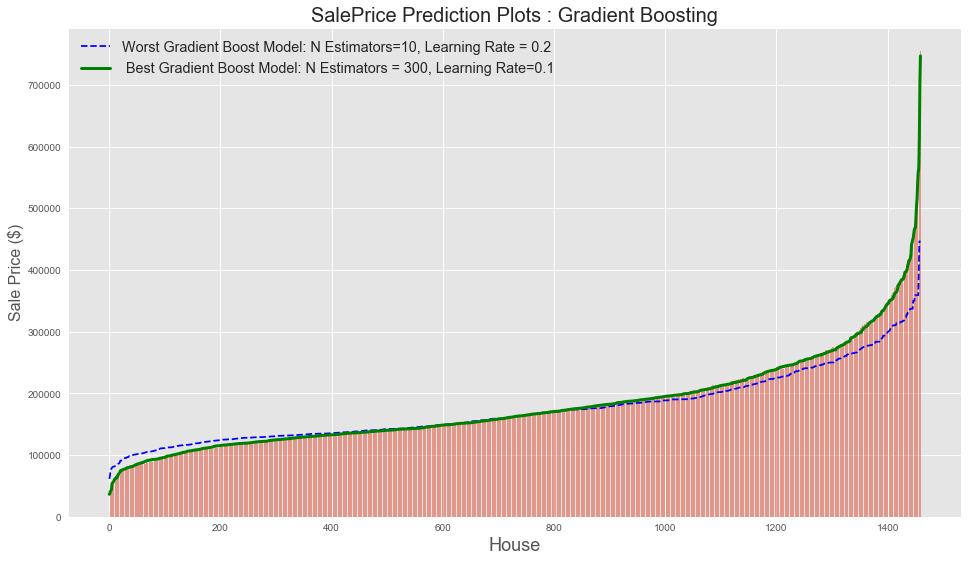

In [62]:

fontP = FontProperties()
fontP.set_size('x-large')
plt.figure(figsize=(16, 9))
plt.bar(range(0,Y_TRAIN.shape[0]),np.exp(sorted(Y_TRAIN)),alpha=0.5)
plt.plot(range(0,Y_TRAIN.shape[0]),np.exp(sorted(worst_gboost_model.predict(X_TRAIN))),color='b',
        linestyle='--', label='Worst Gradient Boost Model: N Estimators=10, Learning Rate = 0.2')
plt.plot(range(0,Y_TRAIN.shape[0]),np.exp(sorted(best_gboost_model.predict(X_TRAIN))),color='g',
        linewidth=3, label=' Best Gradient Boost Model: N Estimators = 300, Learning Rate=0.1')
plt.legend(prop = fontP)
plt.title('SalePrice Prediction Plots : Gradient Boosting',fontsize=20)
plt.xlabel('House', fontsize=18)
plt.ylabel('Sale Price ($)', fontsize=16)

In [60]:
best_gboost_model.get_params

<bound method BaseEstimator.get_params of GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)>

In [36]:
gboost_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.06, min_samples_split=50)
gboost_model.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.06, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=50,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [37]:
print(calc_rmsle(gboost_model,x_train,y_train))
print(calc_rmsle(gboost_model,x_test,y_test))

0.07460535081689688
0.11787888241353053
